In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import torch
import numpy as np
from tqdm.auto import tqdm

from preprocessing import tokenize, embeddings

/home/local_arnab/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data

In [3]:
df = pd.read_csv("Data/df_lyrics.csv")
print(df.shape)
df.head()

(80285, 4)


,Artist,Song,Lyrics,Genre
0,Britney Spears,...Baby One More Time,"Oh, baby, baby Oh, baby, baby Oh, baby, baby...",Pop
1,Britney Spears,Toxic,"Baby, can't you see I'm calling? A guy like y...",Pop
2,Britney Spears,Work Bitch,You wanna? You wanna? You want a hot body? Y...,Pop
3,Britney Spears,Oops!... I Did It Again,"Mmm, yeah Yeah, yeah, yeah, yeah, yeah, yeah ...",Pop
4,Britney Spears,If U Seek Amy,"La, la, la, la, la-la, la, la La, la, la, la,...",Pop


In [4]:
for genre in set(df.Genre):
    print(genre, df[df.Genre == genre].shape[0])

Rap 18331
Pop 18275
Rock 21962
Country 21717


## Preprocessing

In [5]:
tokenizer = tokenize.Tokenizer()
tokenizer.load(path = "Weights/tokenizer.json")
tokenizer.tokenize("I'm a little teapot", get_token_ids=True)

2023-04-08 19:39:56.693206: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


{'tokens': [['<s>', 'I', '_am', '_a', '_little', '_te', 'ap', 'ot', '</s>']],
 'token_ids': [[0, 432, 51, 57, 778, 2153, 1821, 6834, 87]]}

In [6]:
##########################################################
MAX_LENGTH = 1024  # max context length for the tokenizer
##########################################################
lyrics = [l[:min(len(l), MAX_LENGTH)] for l in list(df["Lyrics"])]

proprocessed_lyrics = tokenizer.tokenize(lyrics, get_token_ids=True)

In [7]:
lyrics_token_ids = proprocessed_lyrics["token_ids"]
len(lyrics_token_ids)

80285

In [8]:
shuffle_idx = np.random.permutation(len(lyrics_token_ids))

####################################################################
training_size = 45000
validation_size = 15000
test_size = len(lyrics_token_ids) - training_size - validation_size
####################################################################

training_data = [lyrics_token_ids[i] for i in shuffle_idx[:training_size]]
validation_data = [lyrics_token_ids[i] for i in shuffle_idx[training_size : training_size + validation_size]]
test_data = [lyrics_token_ids[i] for i in shuffle_idx[training_size + validation_size : ]]

print(len(training_data), len(validation_data), len(test_data))

45000 15000 20285


In [9]:
embedder = embeddings.Embedding()
embedder.load("Weights/embeddings_w2v.txt")

In [10]:
embedder.embeddings_size

200

In [11]:
embedder.vocab_size

39903

In [41]:
embedding_matrix = []

for idx in tokenizer.index_word:
    word = tokenizer.index_word[idx]
    vec = embedder.model.get_vector(word)
    embedding_matrix.append(torch.tensor(vec))

embedding_matrix = torch.stack(embedding_matrix)
embedding_matrix.shape

torch.Size([39903, 200])

## Modeling

In [265]:
class RNN(torch.nn.Module):
    def __init__(
            self, 
            embedding_dim, hidden_dim, vocab_size, num_layers = 8,
            pretrained_embeddings = None, # will initialize with random embeddings if None
        ):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.word_embeddings = torch.nn.Embedding(vocab_size, embedding_dim = embedding_dim)
        if(pretrained_embeddings != None):
            self.word_embeddings.weight = torch.nn.Parameter(pretrained_embeddings)
        self.rnn = torch.nn.RNN(
            input_size = embedding_dim, 
            hidden_size = hidden_dim,
            num_layers = num_layers,
            batch_first = True
        )
        self.decoder = torch.nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, input, hidden):
        embeds = self.word_embeddings(input)
        output, hidden = self.rnn(embeds, hidden)
        decoded = self.decoder(output)
        return decoded, hidden

In [266]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

rnn = RNN(
    embedding_dim = embedder.embeddings_size,
    hidden_dim = embedder.embeddings_size,
    vocab_size = embedder.vocab_size,
    pretrained_embeddings = embedding_matrix,
)
rnn.to(device)

RNN(
  (word_embeddings): Embedding(39903, 200)
  (rnn): RNN(200, 200, num_layers=8, batch_first=True)
  (decoder): Linear(in_features=200, out_features=39903, bias=True)
)

In [267]:
next(rnn.parameters()).device

device(type='cuda', index=0)

In [268]:
model_embedder = rnn.word_embeddings
for p in model_embedder.parameters():
    print(p.shape)

torch.Size([39903, 200])


In [269]:
word = "hello"
emb1 = embedder.model.get_vector(word)
emb2 = model_embedder(torch.tensor(tokenizer.word_index[word]).to(device))

print(emb1.shape, emb2.shape)
print(torch.dist(torch.tensor(emb1).to(device), emb2).item())

(200,) torch.Size([200])
0.0


In [270]:
tokenized = tokenizer.tokenize(lyrics[0:5], get_token_ids=True)["token_ids"]
min_length = np.array([len(t) for t in tokenized]).min()
batch = torch.stack(
    [torch.tensor(t[:min_length]) for t in tokenized]
)
batch.shape

torch.Size([5, 270])

In [271]:
# y, h = rnn(
#     input = torch.tensor([[tokenizer.word_index[word]]]).to(device), 
#     hidden = torch.zeros(8, 1, rnn.hidden_dim).to(device)
# )

y, h = rnn(
    input = batch[:, 10][None].T.to(device),
    hidden = None
)

y.shape, h.shape

(torch.Size([5, 1, 39903]), torch.Size([8, 5, 200]))

In [272]:
batch[:, 10][None].T.shape

torch.Size([5, 1])

In [273]:
# cross_entropy(y.squeeze(), torch.tensor(10).to(device))

## Intrinsic Eval

In [ ]:
def perplexity(
        model, sentence_list,
        tokenizer = None,  # if None, assume sentence_list is already tokenized
        batch_size = 32,
        consider_length = 16,   # if the length is too large the perplexity will be infinite
    ):
    model.eval()
    device = next(model.parameters()).device
    if(tokenizer is not None):
        tokenized = tokenizer.tokenize([sentence_list], get_token_ids=True)
        token_ids = tokenized["token_ids"][0]
    else:
        token_ids = sentence_list

    perplexity_track = []
    for batch_start in tqdm(range(0, len(token_ids), batch_size)):
        batch_end = min(len(token_ids), batch_start + batch_size)
        cur_batch_size = batch_end - batch_start
        min_length = min(consider_length, np.array([len(t) for t in token_ids[batch_start : batch_end]]).min())

        batch = torch.stack(
            [torch.tensor(t[:min_length]) for t in token_ids[batch_start : batch_end]]
        ).to(device)
        hidden_state = torch.zeros(
            model.num_layers, cur_batch_size, model.hidden_dim
        ).to(device)

        log_true_proba = 0
        for i in range(min_length - 1):
            x = batch[:, i][None].T
            y_true = batch[:, i+1][None].T
            y_pred, hidden_state = rnn(x, hidden_state)
            cur_log_proba = 0
            for pred, true in zip(y_pred, y_true):
                softmax = torch.nn.functional.softmax(pred.squeeze(), dim = 0)
                # print(true[0].item(), softmax[true[0]].item(), torch.log(softmax[true[0]]).item())
                cur_log_proba += torch.log(softmax[true[0]])
            cur_log_proba /= cur_batch_size
            # print(cur_log_proba.item())
            log_true_proba += cur_log_proba

        proba = torch.exp(log_true_proba.to(torch.float64))
        # print(f"log proba = {log_true_proba.item()}", f"p = {proba.item()}")
        perplexity_track.append(torch.pow(proba, -1/min_length))
    
    return torch.tensor(perplexity_track).mean().item()
        

init_perplexity = perplexity(
    rnn, validation_data, batch_size = 32, consider_length = 32
)

perplexity_track = [init_perplexity]

## Training

In [274]:
learning_rate = 0.001
num_epochs = 10
batch_size = 32

cross_entropy = torch.nn.CrossEntropyLoss()
tunable_params = [
    p for n, p in rnn.named_parameters() if "word_embeddings" not in n # tune all weights but the embeddings
]

optimizer = torch.optim.Adam(tunable_params, lr = learning_rate)

In [275]:
batch_start = 0
batch_end = batch_start + batch_size
tokenized = training_data[batch_start : batch_end]

In [276]:
loss_track = []

loss = 0
for epoch in range(num_epochs):
    rnn.train()
    for batch_start in tqdm(range(0, len(training_data), batch_size)):
        batch_end = min(len(training_data), batch_start + batch_size)
        cur_batch_size = batch_end - batch_start

        tokenized = training_data[batch_start : batch_end]
        min_length = np.array([len(t) for t in tokenized]).min()
        batch = torch.stack(
            [torch.tensor(t[:min_length]) for t in tokenized]
        ).to(device)
        hidden_state = torch.zeros(rnn.num_layers, cur_batch_size, rnn.hidden_dim).to(device)   # start fresh for each sentence
        
        for i in range(min_length - 1):
            x = batch[:, i][None].T
            y_true = batch[:, i+1][None].T
            y_pred, hidden_state = rnn(x, hidden_state)
            for pred, true in zip(y_pred, y_true):
                loss += cross_entropy(pred.squeeze(), true[0])
        
        loss_track.append(loss.item()/cur_batch_size)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        rnn.zero_grad()
        loss = 0
    
    perplexity_track.append(
        perplexity(rnn, validation_data)
    )

100%|██████████| 1407/1407 [07:04<00:00,  3.31it/s]


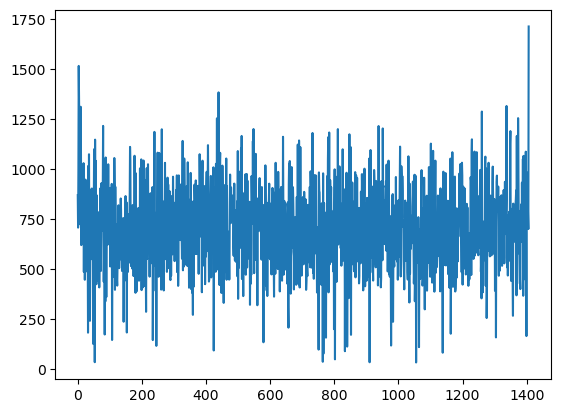

In [277]:
import matplotlib.pyplot as plt

plt.plot(loss_track)

In [278]:
def generate(
        model, tokenizer, 
        prompt="", max_new_tokens = 10, top_k = 5,
        debug = False,
    ):
    model.eval()
    device = next(model.parameters()).device
    tokenized = tokenizer.tokenize([prompt], get_token_ids=True)
    token_ids = tokenized["token_ids"][0][:-1]  # remove the </s> token
    end_of_sent = tokenizer.word_index[tokenizer.SENT_END]

    hidden_state = torch.zeros(model.num_layers, 1, model.hidden_dim).to(device)
    for p in token_ids:
        x = torch.tensor([[p]]).to(device)
        y_pred, hidden_state = model(x, hidden_state)
    
    last_token = token_ids[-1]
    generated_tokens = []
    for i in range(max_new_tokens):
        print(hidden_state.norm().item())
        y_pred, hidden_state = model(
            torch.tensor([[last_token]]).to(device), hidden_state
        )
        y_pred = y_pred.squeeze()
        y_pred = torch.nn.functional.softmax(y_pred, dim = 0)
        y_pred = y_pred.cpu().detach().numpy()
        top_k_idx = y_pred.argsort()[-top_k:][::-1]
        top_k_values = y_pred[top_k_idx]

        if(debug):
            print(top_k_idx)
            print([(tokenizer.index_word[t], np.round(v, 4)) for t, v in zip(top_k_idx, top_k_values)])
        
        top_k_probs = top_k_values / np.sum(top_k_values)
        sampled_idx = np.random.choice(top_k_idx, p = top_k_probs)
        token_ids.append(sampled_idx)
        last_token = sampled_idx
        generated_tokens.append(sampled_idx)
        if(sampled_idx == end_of_sent):
            break
    
    return {
        "text": tokenizer.decode([token_ids + generated_tokens]),
        "generated_tokens": generated_tokens,
    }

        

generate(rnn, tokenizer, "a sample prompt", debug = True)

36.31760025024414
[ 7  2 77 20 57]
[('_I', 0.0511), (',', 0.041), ('_the', 0.0299), ('_you', 0.0219), ('_a', 0.0148)]
36.35867691040039
[ 7  2 77 20 40]
[('_I', 0.0482), (',', 0.0465), ('_the', 0.0288), ('_you', 0.0227), ('_is', 0.0139)]
36.55463409423828
[ 7  2 77 20 57]
[('_I', 0.0479), (',', 0.0473), ('_the', 0.03), ('_you', 0.0232), ('_a', 0.0147)]
36.60169982910156
[ 2  7 77 20 57]
[(',', 0.0478), ('_I', 0.0465), ('_the', 0.0305), ('_you', 0.0235), ('_a', 0.0149)]
36.626468658447266
[ 7  2 77 20 57]
[('_I', 0.0475), (',', 0.0468), ('_the', 0.0305), ('_you', 0.0232), ('_a', 0.0147)]
36.62479782104492
[ 7  2 77 20 57]
[('_I', 0.0475), (',', 0.0467), ('_the', 0.0301), ('_you', 0.0231), ('_a', 0.0145)]
36.608482360839844
[ 7  2 77 20 57]
[('_I', 0.0477), (',', 0.0467), ('_the', 0.0301), ('_you', 0.0231), ('_a', 0.0145)]
36.620445251464844
[ 7  2 77 20 57]
[('_I', 0.0473), (',', 0.0471), ('_the', 0.0302), ('_you', 0.0232), ('_a', 0.0146)]
36.636077880859375
[ 7  2 77 20 57]
[('_I', 0.0

{'text': ['a sample prompt, the I, the, I I,,, the I, the, I I,,'],
 'generated_tokens': [2, 77, 7, 2, 77, 2, 7, 7, 2, 2]}